<a href="https://colab.research.google.com/github/REDFLAG-bugs/MNIST/blob/trannote1/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 0: [0/60000 (0%)]	Loss: 2.309701
Epoch 0: [6400/60000 (11%)]	Loss: 0.607372
Epoch 0: [12800/60000 (21%)]	Loss: 0.450757
Epoch 0: [19200/60000 (32%)]	Loss: 0.135187
Epoch 0: [25600/60000 (43%)]	Loss: 0.275652
Epoch 0: [32000/60000 (53%)]	Loss: 0.316349
Epoch 0: [38400/60000 (64%)]	Loss: 0.347500
Epoch 0: [44800/60000 (75%)]	Loss: 0.309112
Epoch 0: [51200/60000 (85%)]	Loss: 0.193442
Epoch 0: [57600/60000 (96%)]	Loss: 0.283247
Epoch 0: Average loss: 0.3719, Training Accuracy: 89.47%, Test Accuracy: 97.05%
Checkpoint saved: /content/drive/MyDrive/mnist_checkpoints/model_epoch_0_20250220_125532.pt
Epoch 1: [0/60000 (0%)]	Loss: 0.115942
Epoch 1: [6400/60000 (11%)]	Loss: 0.121668
Epoch 1: [12800/60000 (21%)]	Loss: 0.110479
Epoch 1: [19200/60000 (32%)]	Loss: 0.321540
Epoch 1: [25600/60000 (43%)]	Loss: 0.339007
Epoch 1: [32000/60000 (53%)]	Loss: 0.266643
Epoch 1: [38400/60000 (64%)]	Loss: 0.105999
Epoch 1: [44800/60000 (75%)]	Loss: 0.347382
Epoch 1: [51200/60000 (85%)]	Loss: 0.201961
Epoc

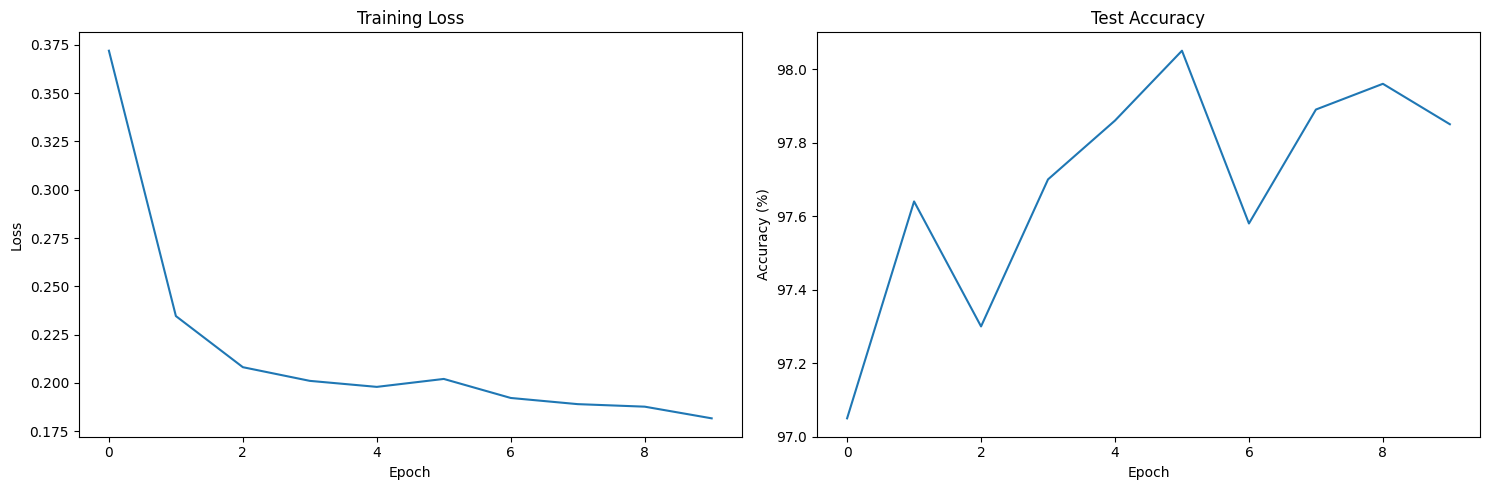

Training progress plot saved: /content/drive/MyDrive/mnist_checkpoints/training_progress.png


In [1]:
# First cell - Mount Google Drive and install dependencies
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import datetime
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Create a directory for checkpoints in Google Drive
CHECKPOINT_DIR = '/content/drive/MyDrive/mnist_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Model Definition
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Training Function
def train_model(model, train_loader, test_loader, epochs=10, learning_rate=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # For plotting
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}: [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        # Calculate average loss and accuracy
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        train_losses.append(avg_loss)

        # Validate the model
        test_accuracy = validate_model(model, test_loader, device)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch}: Average loss: {avg_loss:.4f}, '
              f'Training Accuracy: {accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

        # Save checkpoint to Google Drive
        save_checkpoint(model, optimizer, epoch, avg_loss)

    # Plot training progress
    plot_training_progress(train_losses, test_accuracies)

def validate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    accuracy = 100. * correct / total
    return accuracy

def save_checkpoint(model, optimizer, epoch, loss):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'model_epoch_{epoch}_{timestamp}.pt')

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved: {checkpoint_path}')

def plot_training_progress(train_losses, test_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training loss
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    # Plot test accuracy
    ax2.plot(test_accuracies)
    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

    # Save plot to Drive
    plot_path = os.path.join(CHECKPOINT_DIR, 'training_progress.png')
    fig.savefig(plot_path)
    print(f'Training progress plot saved: {plot_path}')

# Main training code
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load MNIST dataset
    train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('data', train=False, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000)

    # Initialize model
    model = MNISTNet()

    # Train the model
    train_model(model, train_loader, test_loader)

if __name__ == '__main__':
    main()